### Ideas
- Only train on open days
- Filter training set to days queried in the submission

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
train = pd.read_csv("train.csv", parse_dates = ['Date'], dtype={'StateHoliday': str})
test = pd.read_csv("test.csv", parse_dates = ['Date'], dtype={'StateHoliday': str})
store = pd.read_csv("store.csv")

In [3]:
# Drop unnecessary columns from store dataframe
dropped_columns = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval']
store.drop(dropped_columns, axis=1, inplace=True)

# Replace NaNs
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean())

In [4]:
# Sort first by store and then by date
train = train.sort_values(["Store", "Date"])

In [5]:
# Extract values from a date as ints
def parse_date(df):
    df['Year']=df['Date'].dt.year
    df['Month']=df['Date'].dt.month
    df['Day']=df['Date'].dt.day
    df['WeekNumber']=df['Date'].dt.isocalendar().week
    
    df.drop(['Date'], axis=1, inplace=True)

In [6]:
# Parse dates, add store info and split categorical columns into separate vars
def preprocess_data(df):
    parse_date(df)
    df = pd.merge(df, store, on='Store', how='left')
    df = pd.get_dummies(df, columns=['StateHoliday','StoreType', 'Assortment'])
    return df

In [7]:
train = preprocess_data(train)
train.drop(['Customers', 'StateHoliday_b', 'StateHoliday_c'], axis=1, inplace=True)

test = preprocess_data(test)
test.fillna(1, inplace = True)
test.drop(['Id'], axis=1, inplace=True)

In [8]:
# Send Sales column to the end
train = train[[c for c in train if c != 'Sales'] + ['Sales']]

In [9]:
train

,Store,DayOfWeek,Open,Promo,SchoolHoliday,Year,Month,Day,WeekNumber,CompetitionDistance,...,StateHoliday_0,StateHoliday_a,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Sales
0,1,2,0,0,1,2013,1,1,1,1270.0,...,0,1,0,0,1,0,1,0,0,0
1,1,3,1,0,1,2013,1,2,1,1270.0,...,1,0,0,0,1,0,1,0,0,5530
2,1,4,1,0,1,2013,1,3,1,1270.0,...,1,0,0,0,1,0,1,0,0,4327
3,1,5,1,0,1,2013,1,4,1,1270.0,...,1,0,0,0,1,0,1,0,0,4486
4,1,6,1,0,1,2013,1,5,1,1270.0,...,1,0,0,0,1,0,1,0,0,4997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,1,1,1,1,2015,7,27,31,5350.0,...,1,0,0,0,0,1,0,0,1,10712
1017205,1115,2,1,1,1,2015,7,28,31,5350.0,...,1,0,0,0,0,1,0,0,1,8093
1017206,1115,3,1,1,1,2015,7,29,31,5350.0,...,1,0,0,0,0,1,0,0,1,7661
1017207,1115,4,1,1,1,2015,7,30,31,5350.0,...,1,0,0,0,0,1,0,0,1,8405


In [10]:
# Filter by only dates present in test dataset
# train = train[((train['Month'] == 9) & (train['Day'] <= 17)) | (train['Month'] == 8)]

In [11]:
# Scale data
scaler = MinMaxScaler()
train_norm = scaler.fit_transform(train)

sales_min = scaler.data_min_[-1]
sales_range = scaler.data_range_[-1]

In [12]:
# Split into training and validation
x_train, x_val, y_train, y_val = train_test_split(train_norm[:,:-1], train_norm[:,-1], test_size=0.30, shuffle=False)

# Reshape for model
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])

x_train.shape

(712046, 1, 20)

Model: "rossman_sales_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                21760     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 22,817
Trainable params: 22,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5563/5563 [==============================] - 10s 2ms/step - loss: 0.0210 - val_loss: 0.0094
Epoch

Epoch 70/100
5563/5563 [==============================] - 9s 2ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 71/100
5563/5563 [==============================] - 9s 2ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 72/100
5563/5563 [==============================] - 9s 2ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 73/100
5563/5563 [==============================] - 9s 2ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 74/100
5563/5563 [==============================] - 9s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 75/100
5563/5563 [==============================] - 9s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 76/100
5563/5563 [==============================] - 9s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 77/100
5563/5563 [==============================] - 9s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 78/100
5563/5563 [==============================] - 9s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 79/100
5563/5563 [==============================] - 9s 2ms

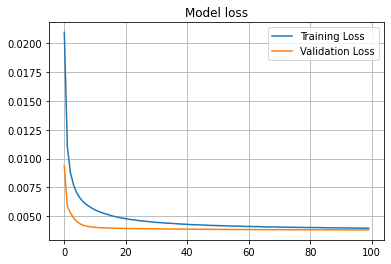

In [13]:
# Build model
model = keras.Sequential(name='rossman_sales_model')
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(16, activation='swish'))
model.add(Dropout(0.4))
model.add(Dense(1))

model.summary()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='mse'
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Train model
history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks = [early_stop],
    verbose=1
)

# Plot model loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.title("Model loss")
plt.legend()
plt.grid()
plt.show()

In [15]:
# Scale test data
scaler = MinMaxScaler()
test_norm = scaler.fit_transform(test)

# Reshape for model
x_test = test_norm.reshape(test_norm.shape[0], 1, test_norm.shape[1])

# Run predictions
test_output = model.predict(x_test, verbose=0)

# Scale predictions back
test_output = test_output * sales_range + sales_min

# Add Id column
new_column = range(1, test.shape[0]+1)
output = np.insert(test_output, 0, new_column, axis=1)

# Construct and format df for submission
submission_df = pd.DataFrame(data=output, columns=["Id", "Sales"])
submission_df["Id"] = submission_df["Id"].astype(int)

# Make negative sales predictions 0
submission_df[submission_df < 0] = 0

# Export
submission_df.to_csv('submission.csv', index=False)